In [184]:
using DataFrames
using Plots, Rsvg
using Chemfiles
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

plotlyjs()

Plots.PlotlyJSBackend()

In [185]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [186]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_middle, out_counts
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

## Freqs / evals

In [3]:
df_Whis_evals_4uet = readtable(joinpath(rtdos, "freq_hist_4uet"), separator = '\t')
df_Whis_evals_4xcp = readtable(joinpath(rtdos, "freq_hist_4xcp"), separator = '\t')
df_Whis_evals = [ df_Whis_evals_4uet ; df_Whis_evals_4xcp ];
df_Whis_evals[:Conformer] = repeat(["4UET", "4XCP"], inner = size(df_Whis_evals_4xcp)[1]);

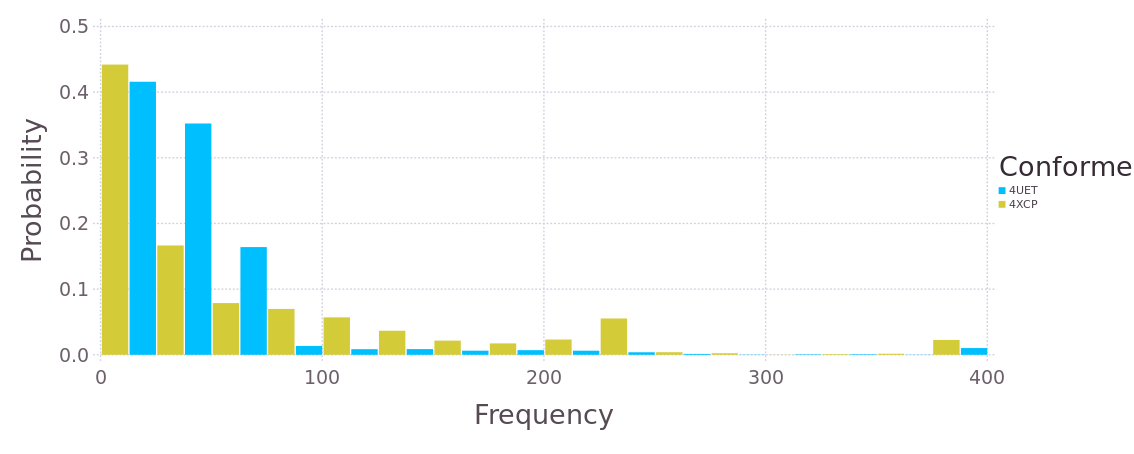

In [4]:
pdf_Whis_evals = plot(df_Whis_evals, x = "Frequency", y = "Probability", color = "Conformer",
    Geom.bar(position=:dodge),
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 300, xmax = 1800, ymax = 0.002),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Volumen

In [20]:
df_Whis_vol_4uet = readtable(joinpath(rtdos, "hist_vol_4uet") , separator = '\t')
df_Whis_vol_4xcp = readtable(joinpath(rtdos, "hist_vol_4xcp") , separator = '\t');
df_Whis_vol = [ df_Whis_vol_4uet ; df_Whis_vol_4xcp ];
df_Whis_vol[:Conformer] = repeat(["4UET", "4XCP"], inner = size(df_Whis_vol_4xcp)[1]);

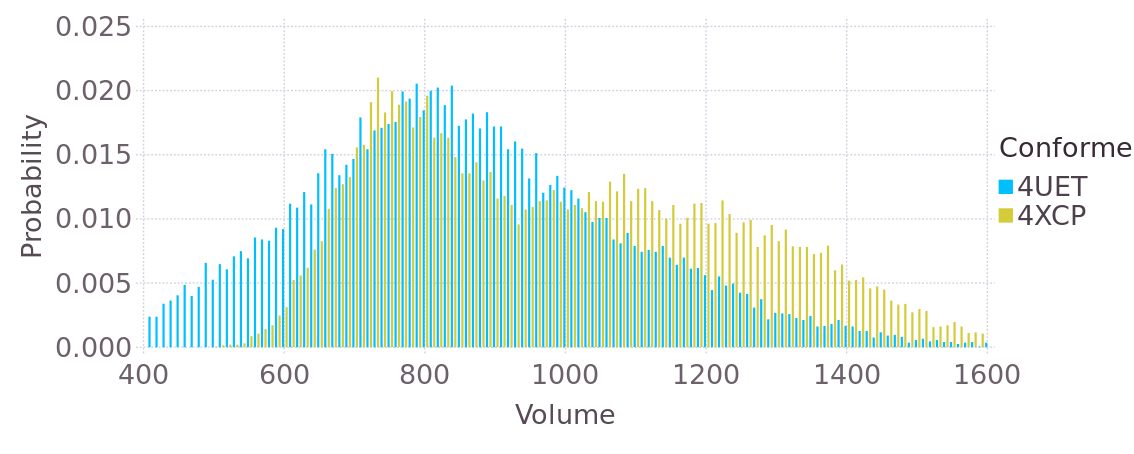

In [24]:
pdf_Whis_vol = plot(df_Whis_vol, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position=:dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 400, xmax = 1600, ymax = 0.025),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 20pt, major_label_font_size = 20pt,
        key_label_font_size = 20pt, key_title_font_size = 20pt))

## Gdte cartesiano

In [22]:
car_vgv_4uet = readdlm(joinpath(rtdos, "car_vgv_4uet"))[:, 1]
car_vgv_4xcp = readdlm(joinpath(rtdos, "car_vgv_4xcp"))[:, 1];

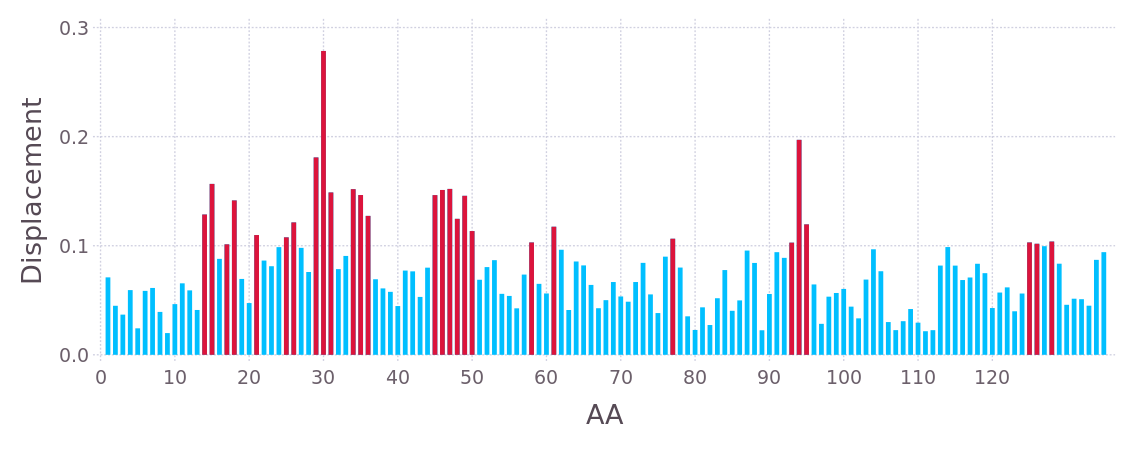

In [8]:
tmp = tognm(car_vgv_4uet)
tmp_ = copy(tmp)
tmp_[tmp_ .< .1] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte_4uet = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    Coord.cartesian(ymax = .301),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))

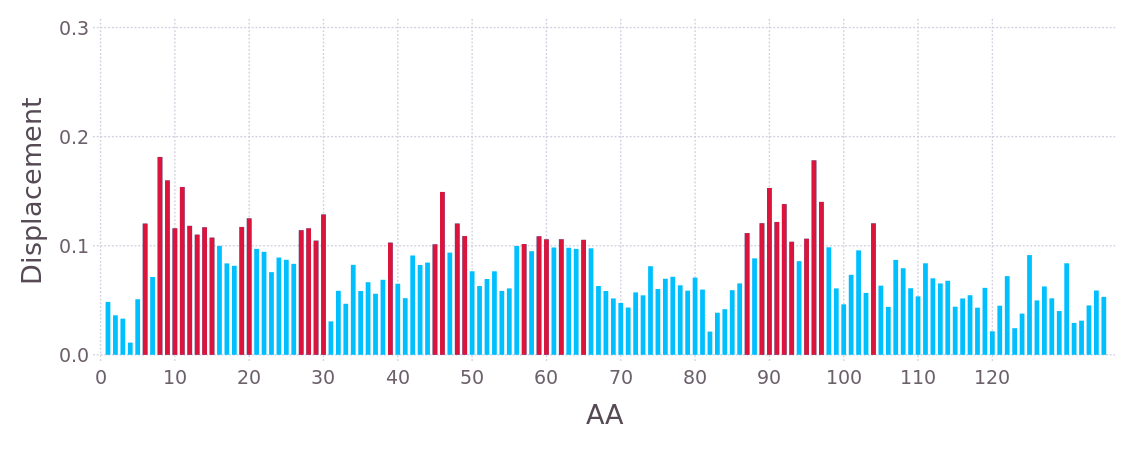

In [9]:
tmp = tognm(car_vgv_4xcp)
tmp_ = copy(tmp)
tmp_[tmp_ .< .1] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte_4xcp = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    Coord.cartesian(ymax = .301),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))

# Energías

In [10]:
E_4uet = readdlm(joinpath(rtdos, "energia_4uet"))[:, 1]
E_4xcp = readdlm(joinpath(rtdos, "energia_4xcp"))[:, 1]

points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

df_E = DataFrame( U = [ E_4uet ; E_4xcp ],
    Displacement = repeat(repeat(collect(mini:1:maxi) * 5E-1, outer = [1]), outer = 2),
    Conformer = repeat(["4UET", "4XCP"], inner = points));

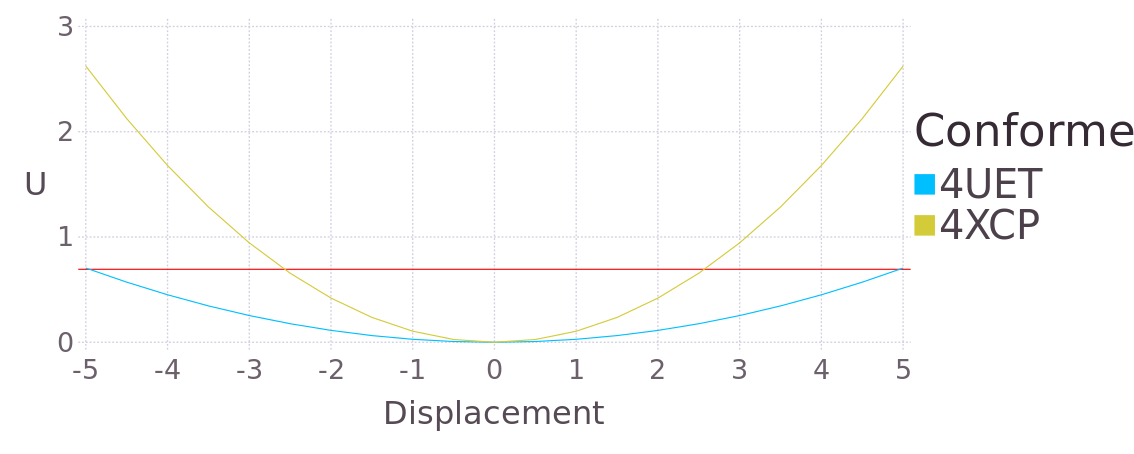

In [11]:
pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Conformer", Geom.line,
    yintercept = [RT], Geom.hline(color = "red"),
    Guide.xticks(ticks = collect(mini:2:maxi) * 5e-1),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
        key_label_font_size = 30pt))

## Más

In [187]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = eval(:(ndd_out_4xcp .- vol_avg_4xcp))
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

pdb = "4uet"
# Leo modos
modes_4uet, evals_4uet = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4uet))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_4uet = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4uet = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4uet = eval(:(ndd_out_4uet .- vol_avg_4uet))
vgv_4uet = vgv_4uet ./ norm(vgv_4uet);

In [ ]:
plt_evals = bar(collect(.83:1.:14.83), 1 ./ evals_4uet[1:15], label = "4UET", bar_width = .33,
    ylims = (0, .301), xticks = collect(1:1:20), yticks = collect(.0:.1:.3),
    xlabel = "Mode number", ylabel = "1 / Frequency [cm]",
    linecolor = false, fillcolor = colorant"#F3ACA2", legend = (.9, .95),
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,  size = (790, 400),
    background_color_legend = :linen)

bar!(collect(1.17:1.:15.17), 1 ./ evals_4xcp[1:15], label = "4XCP", bar_width = .33,
    linecolor = false, fillcolor = colorant"#6a1b9a")

title!("Autovalores")

In [181]:
############## PNG ##############
savefig(plt_evals, joinpath(rtdos, "papel", string("2_plt_evals_", pdb, ".svg")))

# PCA

In [188]:
dif = readdlm(joinpath(rtdos, string("diff_", pdb)))
norm_dif = mapslices(x -> x ./ norm(x), dif, 1)
nframes = size(dif)[2]

prj_1_4xcp = Array{Float64, 1}(nframes)
prj_2_4xcp = Array{Float64, 1}(nframes)
prj_3_4xcp = Array{Float64, 1}(nframes)
prj_4_4xcp = Array{Float64, 1}(nframes)
prj_5_4xcp = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
    
#     prj_4_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 4])
#     prj_5_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 5])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

# smooth_prj_4_4xcp = [ mean(prj_4_4xcp[i:i+9]) for i = 1:10:length(prj_4_4xcp)-9 ]
# smooth_prj_5_4xcp = [ mean(prj_5_4xcp[i:i+9]) for i = 1:10:length(prj_5_4xcp)-9 ];

In [190]:
plt_2his = histogram2d(smooth_prj_1_4xcp, smooth_prj_2_4xcp, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "Projecciones",
    clims = (1, 15), colorbar_title = "Frame count",
    nbins = 200, size = (800, 750))

annotate!(.22, -.69, text("1", 25, :green))
annotate!(.85, .45, text("2", 25, :green))
annotate!(-.0, .95, text("3", 25, :green))
annotate!(-.9, -.35, text("4", 25, :green))

In [ ]:
plt_pca_trj = scatter(smooth_prj_1_4xcp[1:2], smooth_prj_2_4xcp[1:2],
    xlims = (-1., 1.), ylims = (-1., 1.), legend = false,
    yaxis = "PCA 2", xaxis = "PCA 1", title = "PCA projections",
    markersize = 2., markeralpha = .4, markerstrokewidth = .1)

anim = @gif for x = 3:length(smooth_prj_1_4xcp)
    push!(plt_pca_trj, smooth_prj_1_4xcp[x], smooth_prj_2_4xcp[x])
    end every 5

In [ ]:
aa_cav_3 = Array{Int64, 1}(length(aa_cav)*3)
for i in 1:length(aa_cav)
    aa_cav_3[i*3-2] = aa_cav[i] * 3 - 2
    aa_cav_3[i*3-1] = aa_cav[i] * 3 - 1
    aa_cav_3[i*3] = aa_cav[i] * 3
end
uno_uet = modes_4uet[aa_cav_3, 1]
uno_uet = uno_uet ./ norm(uno_uet)

dos_uet = modes_4uet[aa_cav_3, 2]
dos_uet = dos_uet ./ norm(dos_uet)

uno_xcp = modes_4xcp[aa_cav_3, 1]
uno_xcp = uno_xcp ./ norm(uno_xcp)

dos_xcp = modes_4xcp[aa_cav_3, 2]
dos_xcp = dos_xcp ./ norm(dos_xcp);

DataFrame(entero = [ dot(modes_4xcp[:, 1], modes_4uet[:, 1]) ;
        dot(modes_4xcp[:, 2], modes_4uet[:, 2]) ], 
    cut = [ dot(uno_uet, uno_xcp) ;
        dot(dos_uet, dos_xcp) ])

In [ ]:
aa_cav = [1 ; 4 ; 5 ; 6 ; 9 ; 12 ; 13 ; 16 ; 21 ; 24 ; 54 ; 57 ; 58 ; 61 ; 
    65 ; 75 ; 76 ; 79 ; 80 ; 83 ; 84 ; 86 ; 87 ; 90 ; 91 ; 96 ; 101 ; 104 ; 
    105 ; 108 ; 112 ; 123 ; 127 ; 130 ; 131 ; 133 ; 134];
rmsf_4uet = readdlm("/home/german/labo/18/lbp/run/4uet/rmsf/rmsf_4uet")[:, 2]
rmsf_4xcp = readdlm("/home/german/labo/18/lbp/run/4xcp/rmsf/rmsf_4xcp")[:, 2];

df_dat_rms = DataFrame( MEAN = [ mean(rmsf_4uet);mean(rmsf_4xcp) ],
    STD = [ std(rmsf_4uet) ; std(rmsf_4xcp) ])

In [ ]:
df_dat_rms_cav = DataFrame( MEAN =  [ mean(rmsf_4uet[aa_cav]) ; mean(rmsf_4xcp[aa_cav]) ],
 STD = [ std(rmsf_4uet[aa_cav]) ; std(rmsf_4xcp[aa_cav]) ])

In [ ]:
plot(rmsf_4uet, label = "4UET", size = (800, 400))
plot!(rmsf_4xcp, label = "4XCP")
xaxis!("Calfa")
yaxis!("angstrom")
vline!(aa_cav, linestyle = :dot, linecolor = "DarkBlue")

In [ ]:
het_vol = convert(Array{Float64, 1}, 
    readdlm("/home/german/labo/18/lbp/run/4xcp/cavidad/het_vol_trj_4xcp")[:, 3])
vol = convert(Array{Float64, 1}, 
    readdlm("/home/german/labo/18/lbp/run/4xcp/cavidad/vol_trj_4xcp")[:, 3]);
plot(vol)
plot!(het_vol)